[View in Colaboratory](https://colab.research.google.com/github/davidvela/testColabGH/blob/master/W2VEC_0.ipynb)

# Word2Vec Model 

In [0]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Basic word2vec example."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os
import random
import zipfile
import math

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf


In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12683636216176558589, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11297803469
 locality {
   bus_id: 1
 }
 incarnation: 12050249777880991887
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# Step 1: Download the data.

In [0]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception( 'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

# filename = maybe_download('../../_data_tmp/w2v/text8.zip', 31344016)
filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [0]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(filename)
print('Data size', len(vocabulary))

Data size 17005207


In [0]:
len(vocabulary)

17005207

# Step 2: Build the dictionary and replace rare words with UNK token.


In [0]:
vocabulary_size = 50000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:  index = dictionary[word]
        else:                   index = 0  # dictionary['UNK']
        unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary, vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 17005207], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


# Step 3: Function to generate a training batch for the skip-gram model.


In [0]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 2 of
195 term -> 6 a


# Step 4: Build and train a skip-gram model.

In [0]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable( tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable( tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases  = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean( tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,labels=train_labels,inputs=embed,
                     num_sampled=num_sampled,  num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    #norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True)) #keep_dims is deprecated, use keepdims instead
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True)) 

    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup( normalized_embeddings, valid_dataset)
    similarity = tf.matmul(  valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()


# Step 5: Begin training.


In [0]:
model_path = 'w2vmodel'

def restore_model(sess):   
    saver= tf.train.Saver() 
    print("Model restored from file: %s" % model_path)
    saver.restore(sess, model_path)
    
def save_model( sess ):
  saver= tf.train.Saver()
  save_path = saver.save(sess, model_path)

def save_GD( sess ):

  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # PyDrive reference:
  # https://googledrive.github.io/PyDrive/docs/build/html/index.html

  # 2. Create & upload a file text file.
  uploaded = drive.CreateFile({'title': 'w2vmodel'})
  uploaded.SetContentFile('w2vmodel')
  uploaded.Upload()

# run: ________________________________________________
# with tf.Session() as sess:
#   save_model(sess)
  

In [0]:
from datetime import datetime
#Compare training time. 
print("___Start!___" +  datetime.now().strftime('%H:%M:%S')  )

___Start!___11:28:44


In [0]:

num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run(); print('Initialized')
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch( batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
        final_embeddings = normalized_embeddings.eval()
        

Initialized
Average loss at step  0 :  311.138671875
Nearest to history: ivens, etudes, buprenorphine, behavioural, gate, bolivar, mariners, npd,
Nearest to see: corvettes, antiparticles, culprits, decks, mondo, sup, limburg, rarities,
Nearest to most: subroutine, capabilities, repent, squadrons, evacuate, preconceptions, striking, fran,
Nearest to there: kickoff, rattus, coriolis, wonders, exams, desired, debunked, blend,
Nearest to was: supercharger, medium, scantily, lang, g, alamein, exiles, actually,
Nearest to an: bodywork, alfredo, validating, bodyguards, merck, nhra, limit, magnets,
Nearest to four: cleansing, bette, maesa, xxxi, halted, expands, unguided, octavian,
Nearest to so: psychosis, owners, amino, lax, particulate, cultivation, diplomas, enigmas,
Nearest to in: gadamer, eulogy, nikolaevich, ruling, training, benefiting, snowmobiles, shang,
Nearest to first: regimens, jump, plenipotentiary, corrino, strait, estrada, boss, breasts,
Nearest to up: donnell, sleepers, apex,

Average loss at step  44000 :  5.237296615719795
Average loss at step  46000 :  5.236740321993828
Average loss at step  48000 :  5.223909732460975
Average loss at step  50000 :  4.998236906886101
Nearest to history: dasyprocta, behavioural, ize, tunny, phi, gate, arin, png,
Nearest to see: recitative, acapulco, antiparticles, additions, currents, and, nous, are,
Nearest to most: subroutine, capabilities, more, striking, mya, using, convinced, finer,
Nearest to there: it, they, which, wonders, recitative, he, she, sherlock,
Nearest to was: is, were, has, had, by, became, are, been,
Nearest to an: the, alfredo, manhood, monster, returned, compilers, eridanus, derive,
Nearest to four: six, three, five, eight, two, seven, agouti, dasyprocta,
Nearest to so: psychosis, owners, luc, enigmas, impart, holds, diplomas, packers,
Nearest to in: on, at, from, recitative, during, for, dasyprocta, of,
Nearest to first: regimens, ansgar, in, interception, same, amazonas, coke, connectors,
Nearest to u

Average loss at step  96000 :  4.687785006999969
Average loss at step  98000 :  4.593413280785084
Average loss at step  100000 :  4.695470764994622
Nearest to history: thaler, dasyprocta, microsite, ize, homeomorphism, microcebus, bolivar, tunny,
Nearest to see: cardiomyopathy, recitative, but, acapulco, agouti, and, include, antiparticles,
Nearest to most: more, many, some, subroutine, capabilities, finer, penile, mtsho,
Nearest to there: they, it, he, she, wonders, usually, still, recitative,
Nearest to was: is, had, were, has, became, been, by, supercharger,
Nearest to an: acquisitions, alfredo, cardiomyopathy, manhood, compilers, returned, eridanus, whey,
Nearest to four: five, seven, three, six, eight, two, agouti, zero,
Nearest to so: psychosis, possibly, mtsho, dirt, then, but, microcebus, exciting,
Nearest to in: during, at, from, on, within, under, recitative, cebus,
Nearest to first: second, last, next, same, hippolytus, during, ansgar, work,
Nearest to up: out, piazzi, back,

In [0]:
print("___end!___" +  datetime.now().strftime('%H:%M:%S')  )

___end!___11:46:11


# Step 6: Visualize the embeddings.conda udacity

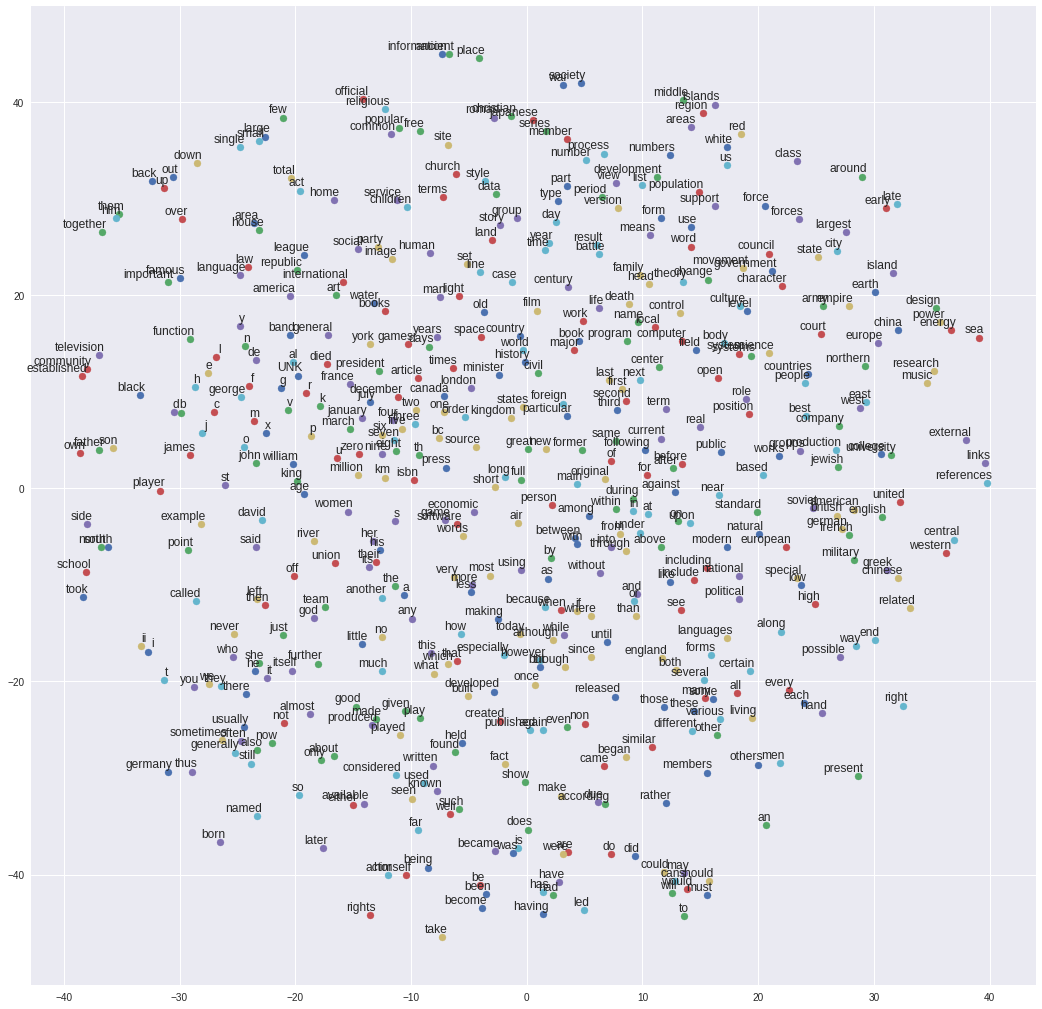

In [0]:
def plot_with_labels(low_dim_embs, labels, filename='./tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),  textcoords='offset points', ha='right',  va='bottom')
    plt.savefig(filename)

try:
    # pylint: disable=g-import-not-at-top
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)
except ImportError:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')

# TESTS

In [0]:
final_embeddings

array([[ 0.02470431, -0.01545255, -0.06389435, ...,  0.01096776,
        -0.02445996, -0.05942179],
       [-0.01419392,  0.07442117,  0.10475092, ..., -0.02388932,
         0.02913963, -0.0900569 ],
       [-0.00505001, -0.00966724, -0.07005214, ..., -0.10385029,
         0.04014368, -0.00294417],
       ...,
       [-0.10557873,  0.13980013, -0.08381534, ...,  0.04723164,
        -0.05302528,  0.06087734],
       [-0.13850908,  0.006161  , -0.13412933, ..., -0.05299753,
        -0.12696785,  0.08155359],
       [ 0.01755815,  0.03613101, -0.14913985, ...,  0.12871562,
         0.07777172,  0.10210498]], dtype=float32)